# Topic Modeling on Research Papers

We will do an interesting exercise here—build topic models on past research papers
from the very popular NIPS conference (now known as the NeurIPS conference). The
late professor Sam Roweis compiled an excellent collection of NIPS Conference Papers
from Volume 1 – 12, which you can find at https://cs.nyu.edu/~roweis/data.html.
An interesting fact is that he obtained this by massaging the OCR’d data from NIPS
1-12, which was actually the pre-electronic submission era. Yann LeCun made the data
available. There is an even more updated dataset available up to NIPS 17 at http://
ai.stanford.edu/~gal/data.html. However, that dataset is in the form of a MAT file, so
you might need to do some additional preprocessing before working on it in Python.


# The Main Objective

Considering our discussion so far, our main objective is pretty simple. Given a whole
bunch of conference research papers, can we identify some key themes or topics from
these papers by leveraging unsupervised learning? We do not have the liberty of labeled
categories telling us what the major themes of every research paper are. Besides that, we
are dealing with text data extracted using OCR (optical character recognition). Hence,
you can expect misspelled words, words with characters missing, and so on, which
makes our problem even more challenging

# Download Data and Dependencies

In [1]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
!tar -xzf nips12raw_str602.tgz

--2020-05-27 15:55:33--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 128.122.49.30
Connecting to cs.nyu.edu (cs.nyu.edu)|128.122.49.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  21.4MB/s    in 0.6s    

2020-05-27 15:55:34 (21.4 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [2]:
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['nips01', 'nips04', 'nips08', 'nips00', 'RAW_DATA_NOTES', 'MATLAB_NOTES', 'nips03', 'nips02', 'orig', 'README_yann', 'nips10', 'nips07', 'nips12', 'nips09', 'nips11', 'nips05', 'idx', 'nips06']


# Load NIPS Research Papers Data

In [4]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

In [6]:
print(papers[3][:1000])

804 
INTRODUCTION TO A SYSTEM FOR IMPLEMENTING NEURAL NET 
CONNECTIONS ON SIMD ARCHITECTURES 
Sherryl Tomboulian 
Institute for Computer Applications in Science and Engineering 
NASA Langley Research Center, Hampton VA 23665 
ABSTRACT 
Neural networks have attracted much interest recently, and using parallel 
architectures to simulate neural networks is a natural and necessary applica- 
tion. The SIMD model of parallel computation is chosen, because systems of 
this type can be built with large numbers of processing elements. However, 
such systems are not naturally suited to generalized communication. A method 
is proposed that allows an implementation of neural network connections on 
massively parallel SIMD architectures. The key to this system is an algorithm 
that allows the formation of arbitrary connections between the 'neurons '. A 
feature is the ability to add new connections quickly. It also has error recov- 
ery ability and is robust over a variety of network topologies. Si

# Basic Text Pre-processing

We perform some basic text wrangling or preprocessing before diving into topic
modeling. We keep things simple here

In [7]:
%%time
import nltk
import tqdm

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

100%|██████████| 1740/1740 [00:30<00:00, 57.64it/s]

1740
CPU times: user 29.8 s, sys: 391 ms, total: 30.2 s
Wall time: 30.2 s


In [8]:
print(norm_papers[0][:50])

['capacity', 'pattern', 'sequence', 'kanerva', 'sdm', 'compared', 'associative', 'memory', 'model', 'james', 'keeler', 'chemistry', 'department', 'stanford', 'university', 'stanford', 'ca', 'riacs', 'nasa', 'ames', 'moffett', 'field', 'ca', 'rnail', 'jdk', 'hydra', 'riacs', 'edu', 'abstract', 'information', 'capacity', 'kanerva', 'sparse', 'distributed', 'memory', 'sdm', 'hopfield', 'type', 'neural', 'network', 'investigated', 'approximation', 'used', 'shown', 'tal', 'information', 'stored', 'system', 'proportional', 'number']


# Build a Bi-gram Phrase Model

Before feature engineering and vectorization, we want to extract some useful bi-gram
based phrases from our research papers and remove some unnecessary terms. We
leverage the very useful gensim.models.Phrases class for this. This capability helps us
automatically detect common phrases from a stream of sentences, which are typically
multi-word expressions/word n-grams. 

This implementation draws inspiration
from the famous paper by Mikolov, et al., “Distributed Representations of Words and
Phrases and their Compositionality,” which you can check out at https://arxiv.org/
abs/1310.4546. We start by extracting and generating words and bi-grams as phrases for
each tokenized research paper. 

We leverage the `min_count` parameter, which tells us that our model ignores all words and bi-grams with total
collected count lower than 20 across the corpus (of the input paper as a list of tokenized
sentences). We also use a `threshold` of 20, which tells us that the model accepts specific
phrases based on this threshold value so that a phrase of words a followed by b is
accepted if the score of the phrase is greater than the threshold of 20. This threshold is
dependent on the scoring parameter, which helps us understand how these phrases are
scored to understand their influence.
Typically the default scorer is used and it’s pretty straightforward to understand.
You can check out further details in the documentation at https://radimrehurek.com/
gensim/models/phrases.html#gensim.models.phrases.original_scorer and in the
previously mentioned research paper.

In [9]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['capacity', 'pattern', 'sequence', 'kanerva', 'sdm', 'compared', 'associative_memory', 'model', 'james', 'keeler', 'chemistry', 'department', 'stanford_university', 'stanford_ca', 'riacs', 'nasa_ames', 'moffett', 'field', 'ca', 'rnail', 'jdk', 'hydra', 'riacs', 'edu_abstract', 'information', 'capacity', 'kanerva_sparse', 'distributed', 'memory', 'sdm', 'hopfield', 'type', 'neural_network', 'investigated', 'approximation', 'used', 'shown', 'tal', 'information', 'stored', 'system', 'proportional', 'number', 'connection', 'net_work', 'proportionality', 'constant', 'sdm', 'hopfield', 'type']


In [10]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '000b'), (1, '100'), (2, '10g2m'), (3, '124a'), (4, '152m'), (5, '15m'), (6, '15n'), (7, '1n'), (8, '22d'), (9, '2b'), (10, '2d'), (11, '2dt'), (12, '2e'), (13, '2jr'), (14, '2mrr')]
Total Vocabulary Size: 78892


Looks like we have a lot of unique phrases in our corpus of research papers,
based on the preceding output. Several of these terms are not very useful since they are
specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way
to achieve this. 

In [11]:
# Filter out words that occur less than 20 documents, or more than 60% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


We removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 60% of all the documents. We are interested in finding
different themes and topics and not recurring themes. Hence, this suits our scenario
perfectly.

# Transforming corpus into bag of words vectors

We can now perform feature engineering by leveraging a simple Bag of Words
model.

In [12]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(7, 1), (9, 1), (14, 1), (15, 1), (16, 26), (20, 1), (32, 1), (33, 1), (35, 6), (36, 2), (38, 1), (42, 1), (45, 1), (46, 1), (49, 2), (50, 2), (51, 1), (54, 7), (55, 5), (59, 1), (60, 1), (65, 1), (75, 1), (82, 1), (83, 1), (97, 1), (101, 1), (103, 28), (106, 1), (108, 5), (110, 7), (111, 8), (120, 1), (129, 1), (130, 7), (131, 4), (134, 1), (139, 13), (143, 1), (145, 1), (148, 2), (155, 2), (156, 1), (160, 1), (161, 4), (164, 1), (176, 1), (177, 6), (185, 3), (189, 3)]


In [13]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('able', 1), ('acad_sci', 1), ('acknowledgement', 1), ('activation', 1), ('activity', 26), ('addition', 1), ('allowed', 1), ('allows', 1), ('alone', 6), ('although', 2), ('american_institute', 1), ('another', 1), ('apart', 1), ('appears', 1), ('approximate', 2), ('approximately', 2), ('approximation', 1), ('associated', 7), ('association', 5), ('assumption', 1), ('assumption_made', 1), ('average', 1), ('behavior', 1), ('biol', 1), ('biological', 1), ('calculation', 1), ('carried', 1), ('cell', 28), ('cerebral', 1), ('change', 5), ('channel', 7), ('characteristic', 8), ('coded', 1), ('compare', 1), ('compared', 7), ('comparison', 4), ('computing', 1), ('connection', 13), ('constant', 1), ('construct', 1), ('context', 2), ('convergence', 2), ('converges', 1), ('corresponding', 1), ('could', 4), ('cross', 1), ('demonstrate', 1), ('demonstrated', 6), ('dependent', 3), ('detail', 3)]


In [14]:
print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


# Topic Models with Latent Dirichlet Allocation (LDA)

The Latent Dirichlet Allocation (LDA) technique is a generative probabilistic model in
which each document is assumed to have a combination of topics similar to a probabilistic
Latent Semantic Indexing model. In this case, the latent topics contain a Dirichlet
prior over them. The math behind in this technique is pretty involved, so we will try to
summarize it since going it specific details is out of the current scope.

![](https://i.imgur.com/l23JAvE.png)

Simplyfying the LDA model process:

![](https://i.imgur.com/0BXCaUi.png)

![](https://i.imgur.com/ioiUAxX.png)

In [16]:
%%time
TOTAL_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 1min 47s, sys: 1.99 s, total: 1min 49s
Wall time: 1min 47s


In [19]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.009*"vector" + 0.006*"unit" + 0.006*"pattern" + 0.006*"neuron" + 0.006*"equation" + 0.005*"matrix" + 0.005*"training" + 0.005*"noise" + 0.005*"dynamic" + 0.004*"linear" + 0.004*"hidden_unit" + 0.004*"solution" + 0.003*"layer" + 0.003*"eq" + 0.003*"rule" + 0.003*"distribution" + 0.003*"rate" + 0.003*"capacity" + 0.003*"state" + 0.003*"attractor"

Topic #2:
0.018*"state" + 0.012*"unit" + 0.009*"task" + 0.008*"action" + 0.006*"step" + 0.006*"representation" + 0.005*"training" + 0.005*"memory" + 0.005*"pattern" + 0.004*"sequence" + 0.004*"policy" + 0.004*"activation" + 0.004*"recurrent" + 0.004*"structure" + 0.003*"net" + 0.003*"hidden_unit" + 0.003*"reinforcement_learning" + 0.003*"architecture" + 0.003*"learn" + 0.003*"environment"

Topic #3:
0.018*"neuron" + 0.017*"cell" + 0.009*"response" + 0.009*"stimulus" + 0.007*"activity" + 0.007*"pattern" + 0.006*"spike" + 0.006*"signal" + 0.005*"synaptic" + 0.004*"cortical" + 0.004*"frequency" + 0.004*"neural" + 0.004*"effect" + 0.004

In [20]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0085059947648578


Topic coherence is a complex topic in its own and it can be used to measure the
quality of topic models to some extent. Typically, a set of statements is said to be
coherent if they support each other. Topic models are unsupervised learning based
models that are trained on unstructured text data, making it difficult to measure the
quality of outputs. 

Refer to Text Analytics with Python 2nd Edition for more detail on this.

In [21]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('training', 0.014), ('classifier', 0.012), ('class', 0.011), ('classification', 0.01), ('node', 0.01), ('pattern', 0.008), ('rule', 0.008), ('feature', 0.007), ('vector', 0.006), ('unit', 0.006), ('tree', 0.005), ('training_set', 0.005), ('test', 0.004), ('trained', 0.004), ('probability', 0.004), ('table', 0.003), ('layer', 0.003), ('task', 0.003), ('experiment', 0.003), ('size', 0.003)]

Topic #2:
[('neuron', 0.018), ('cell', 0.017), ('response', 0.009), ('stimulus', 0.009), ('activity', 0.007), ('pattern', 0.007), ('spike', 0.006), ('signal', 0.006), ('synaptic', 0.005), ('cortical', 0.004), ('frequency', 0.004), ('neural', 0.004), ('effect', 0.004), ('firing', 0.004), ('unit', 0.004), ('connection', 0.004), ('layer', 0.004), ('et_al', 0.003), ('cortex', 0.003), ('change', 0.003)]

Topic #3:
[('class', 0.006), ('distribution', 0.006), ('probability', 0.006), ('variable', 0.005), ('estimate', 0.005), ('sample', 0.005), ('bound', 0.005), ('let', 0.0

In [22]:
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['training', 'classifier', 'class', 'classification', 'node', 'pattern', 'rule', 'feature', 'vector', 'unit', 'tree', 'training_set', 'test', 'trained', 'probability', 'table', 'layer', 'task', 'experiment', 'size']

Topic #2:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'spike', 'signal', 'synaptic', 'cortical', 'frequency', 'neural', 'effect', 'firing', 'unit', 'connection', 'layer', 'et_al', 'cortex', 'change']

Topic #3:
['class', 'distribution', 'probability', 'variable', 'estimate', 'sample', 'bound', 'let', 'approximation', 'kernel', 'linear', 'theorem', 'training', 'size', 'xi', 'optimal', 'vector', 'theory', 'regression', 'note']

Topic #4:
['state', 'control', 'equation', 'convergence', 'optimal', 'controller', 'solution', 'gradient', 'vector', 'dynamic', 'matrix', 'constraint', 'trajectory', 'rate', 'step', 'linear', 'optimization', 'nonlinear', 'energy', 'line']

Topic #5:
['image', 'object', 'visual', 'motion', 'uni

## Evaluating topic model quality

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [23]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.46465493030372984
Avg. Coherence Score (UMass): -1.0085059947648576
Model Perplexity: -7.7898927129844004


# LDA Models with MALLET

The MALLET framework is a Java-based package for statistical natural language
processing, document classification, clustering, topic modeling, information extraction,
and other machine learning applications to text. MALLET stands for MAchine Learning
for LanguagE Toolkit. It was developed by Andrew McCallum along with several people
at the University of Massachusetts Amherst. The MALLET topic modeling toolkit
contains efficient, sampling-based implementations of Latent Dirichlet Allocation,
Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to
download the framework.

In [24]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2020-05-27 16:31:43--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  18.2MB/s    in 0.8s    

2020-05-27 16:31:44 (18.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [25]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=4)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [26]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.50105
perplexity = -8.50105
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.51312347075612
Avg. Coherence Score (UMass): -1.0559523073857255
Model Perplexity: -8.50105


# LDA Tuning: Finding the optimal number of topics

Finding the optimal number of topics in a topic model is tough, given that it is like a
model hyperparameter that you always have to set before training the model. We can
use an iterative approach and build several models with differing numbers of topics and
select the one that has the highest coherence score. 

In [0]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [28]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=4)

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 29/29 [1:35:47<00:00, 198.18s/it]


In [30]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
13,15,0.5492
18,20,0.5425
25,27,0.5404
24,26,0.5367
20,22,0.5366
21,23,0.5365
19,21,0.5353
15,17,0.5342
27,29,0.5340
17,19,0.5327


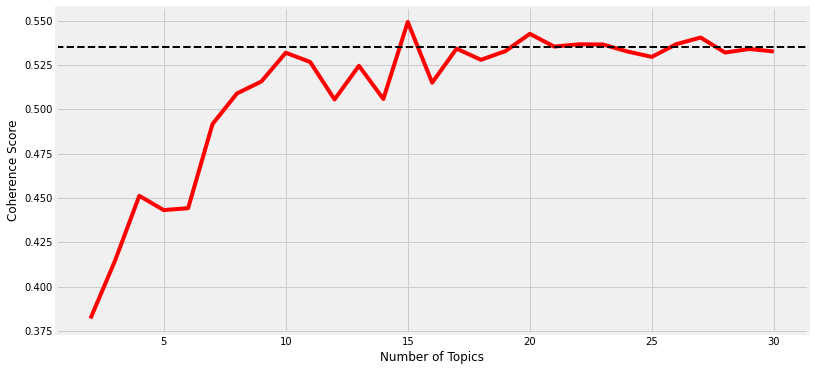

In [31]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

We choose the optimal number of topics as 15, based on our intuition. We can retrieve the best model now

In [32]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 15].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

15

In [33]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['signal', 'noise', 'source', 'frequency', 'filter', 'channel', 'component', 'adaptation', 'detection', 'sound', 'auditory', 'temporal', 'correlation', 'ica', 'response', 'rate', 'phase', 'amplitude', 'coding', 'change']

Topic #2:
['map', 'activity', 'target', 'representation', 'human', 'subject', 'eye', 'motor', 'structure', 'pattern', 'movement', 'stimulus', 'position', 'module', 'visual', 'location', 'development', 'brain', 'response', 'cue']

Topic #3:
['image', 'motion', 'visual', 'direction', 'region', 'field', 'orientation', 'pixel', 'receptive_field', 'location', 'local', 'edge', 'spatial', 'center', 'position', 'velocity', 'object', 'surface', 'response', 'contour']

Topic #4:
['vector', 'matrix', 'solution', 'equation', 'convergence', 'linear', 'gradient', 'constraint', 'rate', 'nonlinear', 'optimal', 'optimization', 'iteration', 'eq', 'update', 'constant', 'minimum', 'energy', 'line', 'gradient_descent']

Topic #5:
['neuron', 'cell', 'response', 'stimulus', 'synap

# Viewing LDA Model topics

In [34]:
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15
Term1,signal,map,image,vector,neuron,dynamic,node,distribution,unit,circuit,word,state,feature,bound,training
Term2,noise,activity,motion,matrix,cell,state,class,probability,layer,chip,sequence,control,image,theorem,prediction
Term3,source,target,visual,solution,response,memory,classification,gaussian,net,current,recognition,action,vector,class,noise
Term4,frequency,representation,direction,equation,stimulus,pattern,classifier,variable,hidden_unit,bit,training,step,representation,size,average
Term5,filter,human,region,convergence,synaptic,neuron,training,prior,training,analog,state,policy,object,theory,training_set
Term6,channel,subject,field,linear,spike,equation,tree,density,rule,neuron,context,task,cluster,probability,test
Term7,component,eye,orientation,gradient,activity,phase,pattern,estimate,pattern,voltage,speech,trajectory,distance,approximation,estimate
Term8,adaptation,motor,pixel,constraint,firing,recurrent,test,mixture,architecture,implementation,character,environment,transformation,threshold,regression
Term9,detection,structure,receptive_field,rate,cortical,attractor,sample,approximation,task,code,hmm,controller,face,complexity,optimal
Term10,sound,pattern,location,nonlinear,pattern,capacity,feature,bayesian,activation,processor,letter,reinforcement_learning,structure,defined,variance


In [35]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"signal, noise, source, frequency, filter, channel, component, adaptation, detection, sound, auditory, temporal, correlation, ica, response, rate, phase, amplitude, coding, change"
Topic2,"map, activity, target, representation, human, subject, eye, motor, structure, pattern, movement, stimulus, position, module, visual, location, development, brain, response, cue"
Topic3,"image, motion, visual, direction, region, field, orientation, pixel, receptive_field, location, local, edge, spatial, center, position, velocity, object, surface, response, contour"
Topic4,"vector, matrix, solution, equation, convergence, linear, gradient, constraint, rate, nonlinear, optimal, optimization, iteration, eq, update, constant, minimum, energy, line, gradient_descent"
Topic5,"neuron, cell, response, stimulus, synaptic, spike, activity, firing, cortical, pattern, connection, synapsis, et_al, neural, effect, cortex, current, threshold, neuronal, layer"
Topic6,"dynamic, state, memory, pattern, neuron, equation, phase, recurrent, attractor, capacity, fixed_point, correlation, hopfield, fig, behavior, stable, theory, delay, noise, connection"
Topic7,"node, class, classification, classifier, training, tree, pattern, test, sample, feature, search, table, technique, experiment, rbf, expert, training_set, accuracy, machine, application"
Topic8,"distribution, probability, gaussian, variable, prior, density, estimate, mixture, approximation, bayesian, sample, estimation, component, likelihood, log, em, step, variance, entropy, posterior"
Topic9,"unit, layer, net, hidden_unit, training, rule, pattern, architecture, task, activation, trained, back_propagation, hidden_layer, learn, connection, hidden, generalization, backpropagation, connectionist, step"
Topic10,"circuit, chip, current, bit, analog, neuron, voltage, implementation, code, processor, design, operation, element, parallel, neural, computation, device, digital, architecture, implemented"


# Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of
topics in each document (research paper in this case).

We can now get the most dominant topic per research paper with some intelligent
sorting and indexing.

In [36]:
tm_results = best_lda_model[bow_corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [37]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(5, 0.41996464028287767),
 (4, 0.5856681949397182),
 (5, 0.19490434142752022),
 (9, 0.5570885822835433),
 (4, 0.31967670011148275)]

In [0]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

# Dominant Topics in Specific Research Papers

Another interesting perspective is to select specific papers, view the most dominant topic
in each of those papers, and see if that makes sense.

In [47]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1288,1,61.78,"signal, noise, source, frequency, filter, channel, component, adaptation, detection, sound, auditory, temporal, correlation, ica, response, rate, phase, amplitude, coding, change","Extended ICA Removes Artifacts from \nElectroencephalographic Recordings \nTzyy-Ping Jung , Colin Humphries , Te-Won Lee , Scott Makeig 2'3, \nMartin J. McKeown , Vicente Iragui 3, Terrence J...."
2,416,2,65.52,"map, activity, target, representation, human, subject, eye, motor, structure, pattern, movement, stimulus, position, module, visual, location, development, brain, response, cue","Further Studies of a Model for the \nDevelopment and Regeneration \nof Eye-Brain Maps \nJ.D. Cowan & A.E. Friedman \nDepartment of Mathematics, Committee on \nNeurobiology, and Brain Research Inst..."
3,1100,3,60.64,"image, motion, visual, direction, region, field, orientation, pixel, receptive_field, location, local, edge, spatial, center, position, velocity, object, surface, response, contour","A \nNeural Network Model of 3-D \nLightness Perception \nLuiz Pessoa \nFederal Univ. of Rio de Janeiro \nRio de Janeiro, RJ, Brazil \npessoa@cos.ufrj.br \nWilliam D. Ross \nBoston University \nBos..."
4,1272,4,62.44,"vector, matrix, solution, equation, convergence, linear, gradient, constraint, rate, nonlinear, optimal, optimization, iteration, eq, update, constant, minimum, energy, line, gradient_descent","A Convergence Proof for the Softassign \nQuadratic Assignment Algorithm \nAnand Rangarajan \nDepartment of Diagnostic Radiology \nYale University School of Medicine \nNew Haven, CT 06520-8042 \ne-..."
5,571,5,77.11,"neuron, cell, response, stimulus, synaptic, spike, activity, firing, cortical, pattern, connection, synapsis, et_al, neural, effect, cortex, current, threshold, neuronal, layer","Network activity determines \nspatio-temporal integration in single cells \njvind Bernander, Christof Koch * \nComputation and Neural Systems Program, \nCalifornia Institute of Technology, \nPasa..."
6,180,6,67.99,"dynamic, state, memory, pattern, neuron, equation, phase, recurrent, attractor, capacity, fixed_point, correlation, hopfield, fig, behavior, stable, theory, delay, noise, connection","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
7,314,7,70.68,"node, class, classification, classifier, training, tree, pattern, test, sample, feature, search, table, technique, experiment, rbf, expert, training_set, accuracy, machine, application","A Comparative Study of the Practical \nCharacteristics of Neural Network and \nConventional Pattern Classifiers \nKenney Ng \nBBN Systems and Technologies \nCambridge, MA 02138 \nAbstract \nRichar..."
8,1607,8,64.08,"distribution, probability, gaussian, variable, prior, density, estimate, mixture, approximation, bayesian, sample, estimation, component, likelihood, log, em, step, variance, entropy, posterior","The Infinite Gaussian Mixture Model \nCarl Edward Rasmussen \nDepartment of Mathematical Modelling \nTechnical University of Denmark \nBuilding 321, DK-2800 Kongens Lyngby, Denmark \ncarl@imm.dtu...."
9,776,9,66.23,"unit, layer, net, hidden_unit, training, rule, pattern, architecture, task, activation, trained, back_propagation, hidden_layer, learn, connection, hidden, generalization, backpropagation, connect...","Analyzing Cross Connected Networks \nThomas R. Shultz \nDepartment of Psychology & \nMcGill Cognitive Science Centre \nMcGill University \nMontr6al, Qu6bec, Canada H3A lB 1 \nsh ultz@ psych. mcgil..."


In [48]:
sample_paper_patterns = ['Feudal Reinforcement Learning \nPeter', 'Illumination-Invariant Face Recognition with a', 'Improved Hidden Markov Model Speech Recognition']
sample_paper_idxs = [idx for pattern in sample_paper_patterns 
                            for idx, content in enumerate(papers) 
                                if pattern in content]
sample_paper_idxs

[661, 716, 504]

In [49]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin(sample_paper_idxs)])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
504,504,11,42.33,"word, sequence, recognition, training, state, context, speech, character, hmm, letter, language, frame, string, symbol, speaker, recurrent, trained, speech_recognition, phoneme, experiment","Improved Hidden Markov Model \nSpeech Recognition Using \nRadial Basis Function Networks \nElliot Singer and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108, USA \nAbstrac..."
661,661,12,58.21,"state, control, action, step, policy, task, trajectory, environment, controller, reinforcement_learning, goal, robot, optimal, current, reward, move, learned, trial, path, td","Feudal Reinforcement Learning \nPeter Dayan \nCNL \nThe Salk Institute \nPO Box 85800 \nSan Diego CA 92186-5800, USA \ndayanhelmholtz. sdsc. edu \nGeoffrey E Hinton \nDepartment of Computer Scien..."
716,716,13,37.79,"feature, image, vector, representation, object, cluster, distance, transformation, face, structure, view, clustering, recognition, part, dimension, mapping, similarity, dimensional, digit, pca","Illumination-Invariant Face Recognition with a \nContrast Sensitive Silicon Retina \nJoachim M. Buhmann \nRheinische Friedrich-Wilhelms-Universitfit \nInstitut ftir Informatik II, R6merstrage 164 ..."
